[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/4.4.classifier_eval.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

## Классификатор. Инференс и метрики

In [2]:
colab = False

if colab == True:
    
    #!pip install fiftyone
    !pip install kaggle

    from google.colab import drive
    drive.mount('/content/drive')
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    
    !mkdir data

    !kaggle datasets download watchman/rtsd-dataset
    !mkdir data/RTSD
    !unzip -q rtsd-dataset.zip -d ./data/RTSD/
    !rm rtsd-dataset.zip
    !cp -r data/RTSD/rtsd-frames/rtsd-frames/ data/RTSD
    !rm -r data/RTSD/rtsd-frames/rtsd-frames/

In [151]:
import json
import os
import numpy as np 
#import pandas as pd 

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

### Пути и параметры

In [4]:
checkpoints_path = 'checkpoints' if colab == False else '../content/drive/MyDrive/TSR/checkpoints'
saved_data_path  = 'data' if colab == False else '../content/drive/MyDrive/TSR/data'

### Графики лоссов и метрик классификаторов

TO DO

- в файлах сделать сначала описание потом флаг model, checkpoint, losses:
  - классификатор - ОК   
  - детектор
  - детектор все классы

In [6]:
def plot_loss_metrics(file_path, plot_losses=False):
    
    if plot_losses == True:
        n_plots=3
    else:
        n_plots=2
    
    # загрузка метрик
    if file_path.split('.')[-1] == 'json':
        with open(file_path, 'r') as read_file:
            losses_metrics = json.load(read_file)
        read_file.close()
    else:
        losses_metrics = torch.load(file_path, map_location='cpu')

    model_name = os.path.basename(file_path).replace('_metrics','').replace('metrics_','').replace('.json','').replace('.pth','').replace('.pt','')

    f1_micro_best = max(losses_metrics['f1_micros_valid'])
    best_epoch = losses_metrics['f1_micros_valid'].index(f1_micro_best)
    f1_macro_best_epoch = losses_metrics['f1_macros_valid'][best_epoch]

    fig, ax = plt.subplots(nrows=1,ncols=n_plots)
    fig.suptitle(model_name)

    if plot_losses == True:
        ax[0].plot(losses_metrics['losses_train'], label='Train')
        ax[0].plot(losses_metrics['losses_valid'], label='Val')    
        ax[0].set_title('Loss')
        ax[0].set(xlabel='Epoch')
        ax[0].legend()
    
    ax[n_plots-2].plot(losses_metrics['f1_micros_train'], label='Train')
    ax[n_plots-2].plot(losses_metrics['f1_micros_valid'], label='Val')      
    ax[n_plots-2].axhline(y = f1_micro_best, color = 'r', linestyle = ':', label='Best epoch') 
    ax[n_plots-2].set_title('F1 micro')
    ax[n_plots-2].set(xlabel='Epoch')
    ax[n_plots-2].legend()

    ax[n_plots-1].plot(losses_metrics['f1_macros_train'], label='Train')
    ax[n_plots-1].plot(losses_metrics['f1_macros_valid'], label='Val')      
    ax[n_plots-1].axhline(y = f1_macro_best_epoch, color = 'r', linestyle = ':', label='Best epoch') 
    ax[n_plots-1].set_title('F1 macro')
    ax[n_plots-1].set(xlabel='Epoch')
    ax[n_plots-1].legend()

    fig.set_size_inches(14, 4)
    plt.subplots_adjust(hspace=0,wspace=0.2)
    plt.show()
    
    print(f'На {best_epoch} эпохе F1 micro - {f1_micro_best:.4f}, F1 macro - {f1_macro_best_epoch:.4f} (нумерация с 0 эпохи)')

    return None

In [7]:
def plot_summary_metrics(plot_title, dict_name_metricsfile):
    
    fig, ax = plt.subplots(nrows=1,ncols=2)#, sharey=True)
    fig.suptitle(plot_title)
    
    for plot_name in dict_name_metricsfile:
        
        file_path = dict_name_metricsfile[plot_name]

        # загрузка метрик
        if file_path.split('.')[-1] == 'json':
            with open(file_path, 'r') as read_file:
                losses_metrics = json.load(read_file)
            read_file.close()
        else:
            losses_metrics = torch.load(file_path, map_location='cpu')

        ax[0].plot(losses_metrics['f1_micros_valid'], label=plot_name)
        ax[1].plot(losses_metrics['f1_macros_valid'], label=plot_name)
    
    ax[0].set_title('F1 micro val')
    ax[0].set(xlabel='Epoch')
    ax[0].legend()

    ax[1].set_title('F1 macro val')
    ax[1].set(xlabel='Epoch')
    ax[1].legend()

    fig.set_size_inches(14, 4)
    plt.subplots_adjust(hspace=0,wspace=0.2)
    plt.show()

    return None

### Сводная таблица с F1 для разных аугментаций torchvision

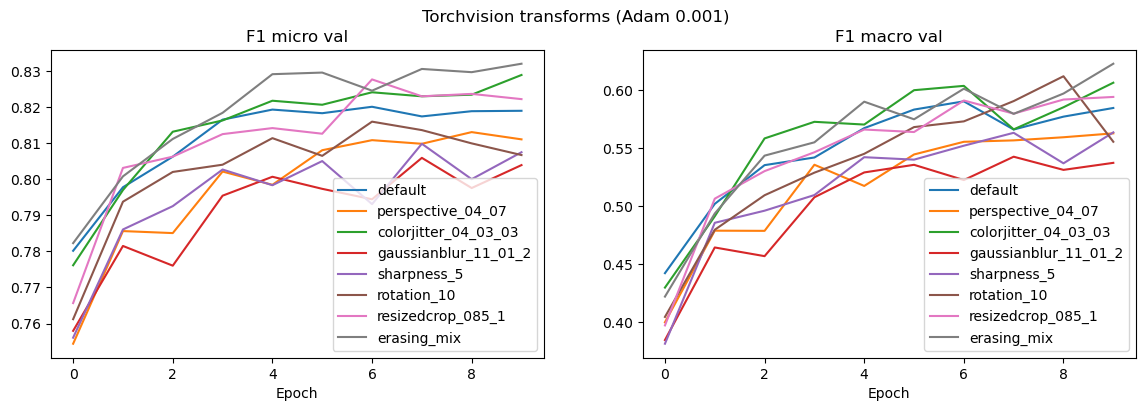

In [8]:
plot_summary_metrics("Torchvision transforms (Adam 0.001)",
                     {'default':os.path.join('checkpoints','classifier_resnet152_test_with_bg_v100_tvs_default_adam_001_metrics.json'),
                      'perspective_04_07':os.path.join('checkpoints','classifier_resnet152_test_with_bg_v100_tvs_perspective_04_07_adam_001_metrics.json'),
                      'colorjitter_04_03_03':os.path.join('checkpoints','classifier_resnet152_test_with_bg_v100_tvs_colorjitter_04_03_03_adam_001_metrics.json'),
                      'gaussianblur_11_01_2':os.path.join('checkpoints','classifier_resnet152_test_with_bg_v100_tvs_gaussianblur_11_01_2_adam_001_metrics.json'),
                      'sharpness_5':os.path.join('checkpoints','classifier_resnet152_test_with_bg_v100_tvs_sharpness_5_adam_001_metrics.json'),
                      'rotation_10':os.path.join('checkpoints','classifier_resnet152_test_with_bg_v100_tvs_rotation_10_adam_001_metrics.json'),
                      'resizedcrop_085_1':os.path.join('checkpoints','classifier_resnet152_test_with_bg_v100_tvs_resizedcrop_085_1_adam_001_metrics.json'),
                      'erasing_mix':os.path.join('checkpoints','classifier_resnet152_test_with_bg_v100_tvs_erasing_1_04_0003_01_2_06_0003_005_2_06_0003_002_5_06_0001_001_adam_001_metrics.json')
                      })

Изменение яркости и контрастности, удаление случайных участков изображения и масштабирование и обрезка увиличили F1, остальные ухудшили

### Сводная таблица с F1 для аугментации Torchvision (все преобразования и лучшие преобразования), аугментации с помощью Albumentations и без преобразования

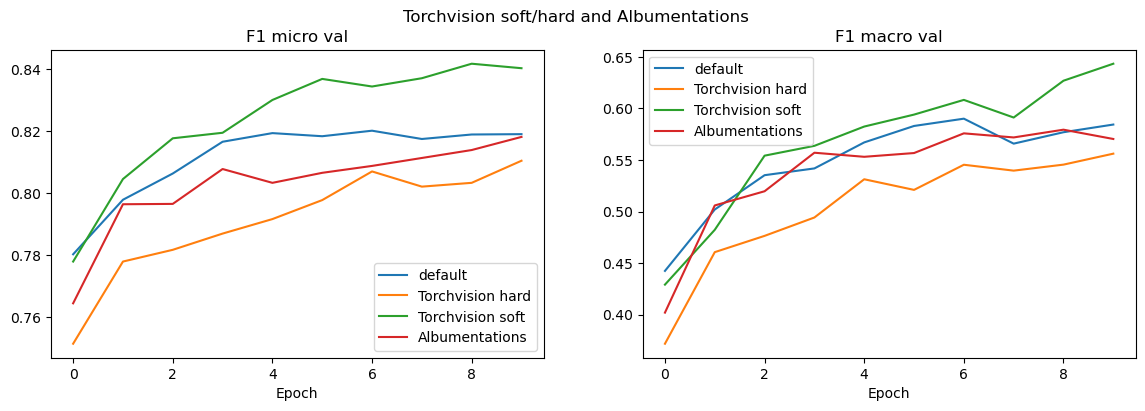

In [9]:
plot_summary_metrics("Torchvision soft/hard and Albumentations",
                     {'default':os.path.join('checkpoints','classifier_resnet152_test_with_bg_v100_tvs_default_adam_001_metrics.json'),
                      'Torchvision hard':os.path.join('checkpoints','classifier_resnet152_bg100_tvs_full_colorjitter_04_03_03_resizedcrop_085_1_erasing_adam_001_metrics.json'),
                      'Torchvision soft':os.path.join('checkpoints','classifier_resnet152_bg100_tvs_randomchoice_perspective_colorjitter_resizedcrop_erasing_adam_001_metrics.json'),
                      'Albumentations':os.path.join('checkpoints','classifier_resnet152_bg100_alb_full_brightnesscontrast_03_03_p08_fog_p005_rain_p005_rotate_10_p05_adam_001_metrics.json')
                      })

### Сравнение разных оптимизаторов

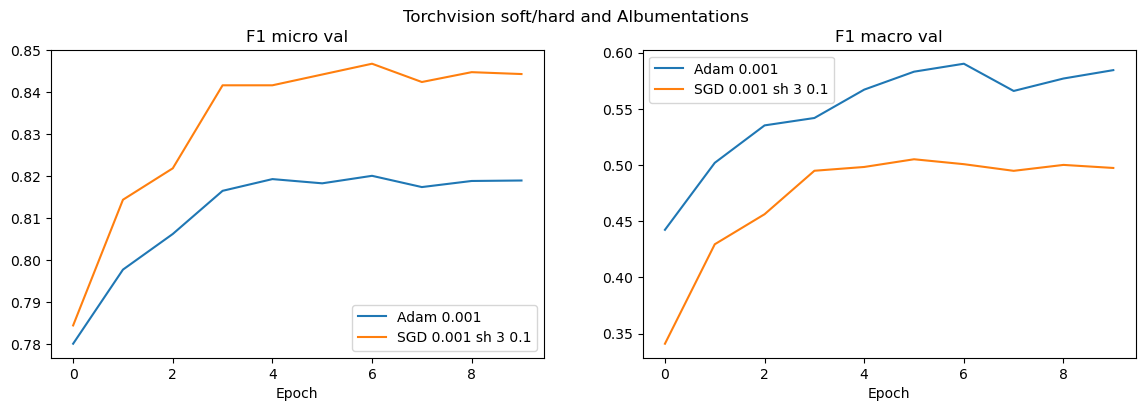

In [10]:
plot_summary_metrics("Torchvision soft/hard and Albumentations",
                     {'Adam 0.001':os.path.join('checkpoints','classifier_resnet152_test_with_bg_v100_tvs_default_adam_001_metrics.json'),
                      'SGD 0.001 sh 3 0.1':os.path.join('checkpoints','classifier_resnet152_default_sgd_005_sh_3_01_metrics.json'),
                      })

### Обучение с использованием данных из дополнительных датасетов

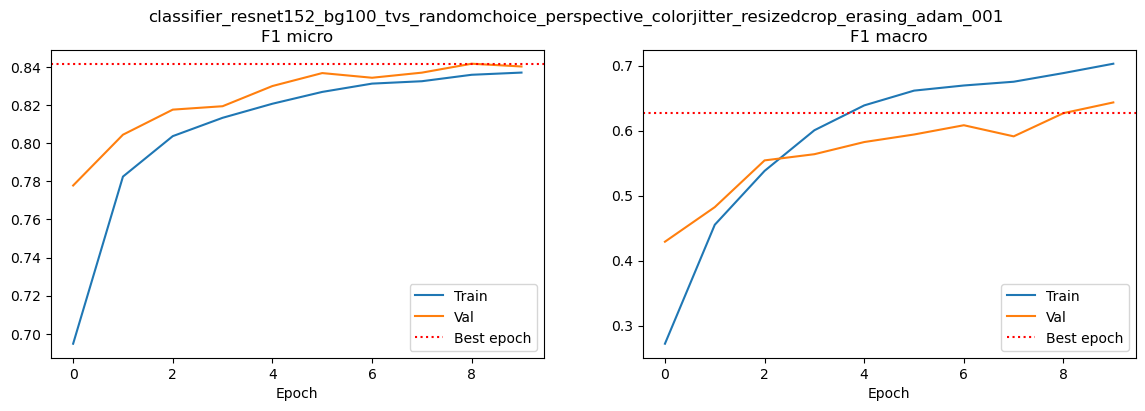

На 8 эпохе F1 micro - 0.8417, F1 macro - 0.6270 (нумерация с 0 эпохи)


In [14]:
plot_loss_metrics(os.path.join('checkpoints','classifier_resnet152_bg100_tvs_randomchoice_perspective_colorjitter_resizedcrop_erasing_adam_001_metrics.json'))

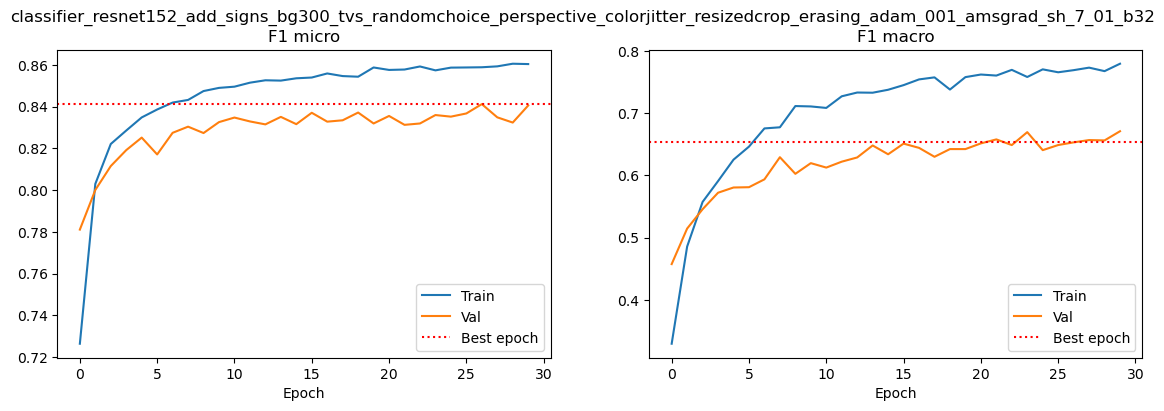

На 26 эпохе F1 micro - 0.8412, F1 macro - 0.6532 (нумерация с 0 эпохи)


In [16]:
plot_loss_metrics(os.path.join('checkpoints', 'classifier_resnet152_add_signs_bg300_tvs_randomchoice_perspective_colorjitter_resizedcrop_erasing_adam_001_amsgrad_sh_7_01_b32_metrics.json'))

## Инференс классификатора

In [21]:
class dataset_for_classifier(Dataset):
    '''
    Класс объединяет объекты датасетов с аннотацией в формате COCO в один датасет
    При обращении к объекту он кадрируется по ограничивающей рамке
   
    параметры:
    images_anno_paths - список кортежей или списков с путями к изображениям и путями к аннотациям
    transforms        - набор преобразований изображения (аугментации, преобразование в тензор)
    samples_in_class  - при задании значения берется заданное количество экземплров класса
    bbox_expand_perc  - процент, на который увеличивается ограничивающая рамка знака
    bbox_expand_pixel - минимальное количество пикселей, на которое увеличивается ограничивающая рамка знака
    '''
    def __init__(self, images_anno_paths, transforms, samples_in_class=None,
                 bbox_expand_perc=None, bbox_expand_pixel=None):
        super().__init__()
        
        self.anno = self.make_anno_list(images_anno_paths)
        #self.anno = self.make_anno_df(images_anno_paths)
        
        # балансировка классов равным количество сэмплов
        if samples_in_class is not None:
            self.data_sampling(samples_in_class)

        self.transforms = transforms
        self.bbox_expand_perc = bbox_expand_perc/100 if bbox_expand_perc is not None else 0
        self.bbox_expand_pixel = bbox_expand_pixel if bbox_expand_pixel is not None else 0

    def __len__(self):      
        return len(self.anno)

    def __getitem__(self, index):
        
        if type(self.anno).__name__ == 'list':
            img_name = self.anno[index]['file_name']
            bbox = self.anno[index]['bbox']
            if (self.bbox_expand_perc !=0) or (self.bbox_expand_pixel !=0):
                width = self.anno[index]['width']
                height = self.anno[index]['height']
                bbox = self.expand_bbox(bbox, width, height)
            label = torch.tensor(self.anno[index]['category_id'])
        else:
            img_name = self.anno.at[index,'file_name']
            bbox = self.anno.at[index,'bbox']
            if (self.bbox_expand_perc is not None) or (self.bbox_expand_pixel is not None):
                width = self.anno.at[index,'width']
                height = self.anno.at[index,'height']
                bbox = self.expand_bbox(bbox, width, height)
            label = torch.tensor(self.anno.at[index,'category_id'])

        # Загрузка изображения
        #img = cv2.imread(os.path.join(self.root, path))
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # загрузка с помощью PIL оказалась быстрее, чем с помощью OpenCV
        img = Image.open(img_name)
        img = img.crop(bbox)
        
        img = self.transform(img)

        return {'images':img, 'labels':label}
    
    def make_anno_list(self, images_anno_paths):

        new_anno = []
        id=0                            # новый ID аннотации (нумерация сквозная)
        
        # для каждого файла аннотации в списке аннотаций
        for images_path, anno_path in images_anno_paths:
            
            # загрузка аннотации
            with open(anno_path, 'r') as read_file:
                anno = json.load(read_file)

            # аннотации изображений для более быстрого поиска по ID
            images_anno = {item['id']:item for item in anno['images']}
            # аннотации категорий для более быстрого поиска по ID
            categories_anno = {item['id']:item for item in anno['categories']}
            
            for annotation in anno.get('annotations'):
                
                sample = {}
                sample['id'] = id
                
                image_id = annotation['image_id']
                anno_image = images_anno[image_id]
                sample['file_name'] = os.path.join(images_path, anno_image['file_name'])
                sample['width'] = anno_image['width']
                sample['height'] = anno_image['height']

                x1, y1, w, h = annotation['bbox']
                sample['bbox'] = [round(x1), round(y1), round(x1+w), round(y1+h)]

                category_id = annotation['category_id']
                sample['category_id'] = category_id
                if category_id==0:
                    sample['category_name'] = 'background'
                else:
                    sample['category_name'] = categories_anno[category_id]['name']
                
                new_anno.append(sample)
                id+=1
        
        return new_anno
    
    def make_anno_df(self, images_anno_paths):

        # для каждого файла аннотации в списке аннотаций
        for images_path, anno_path in images_anno_paths:
            
            # загрузка аннотации
            with open(anno_path, 'r') as read_file:
                anno = json.load(read_file)

            # Загрузка аннотаций в датафрейм
            df_anno = pd.DataFrame(anno.get('annotations')) 
            
            # преобразование столбца bbox из формата COCO (x1, y1, w, h) в формат (x1, y1, x2, y2) и округление
            df_anno['bbox'] = df_anno['bbox'].apply(lambda x: [round(x[0]), round(x[1]), round(x[0] + x[2]), round(x[1] + x[3])])

            # Добавление путей к файлам
            
            df_images = pd.DataFrame(anno.get('images'))
            df_images['file_name'] = df_images['file_name'].apply(lambda x: os.path.join(images_path, x))
            df_anno = df_anno.merge(df_images, left_on='image_id', right_on='id')
            
            # Добавление имен категорий (кодов знаков)
            df_category = pd.DataFrame(anno.get('categories'))
            df_anno = df_anno.merge(df_category, left_on='category_id', right_on='id')[['file_name','width','height',
                                                                                          'bbox','category_id','name']]
            df_anno.rename(columns={'name':'category_name'}, inplace=True)
            
            # конкатенируем полученный датасет с общим датасетом
            try:
                new_anno = pd.concat((new_anno, df_anno), ignore_index=True)    
            except:      # если общего датасета еще нет - присваиваем ему полученный датасет
                new_anno = df_anno

        return new_anno
    
    def data_sampling(self, samples_in_class):
        if type(self.anno).__name__ == 'list':
            new_anno = []
            id=0
            categories = list(set([item['category_id'] for item in self.anno]))
            for category_id in categories:
                category_samples = [x for x in self.anno if x['category_id'] == category_id]
                for i in range(samples_in_class):
                    sample = random.choice(category_samples)
                    sample['id'] = id
                    new_anno.append(sample)
                    id+=1
                    
            self.anno = new_anno

        else:
            self.anno = self.anno.groupby('category_id', group_keys= False).apply(lambda x: x.sample(samples_in_class, replace=True))
            self.anno.reset_index(inplace=True)
            del self.anno['index']

    def expand_bbox(self, bbox, width, height):
        sign_w = bbox[2] - bbox[0]          # ширина знака
        sign_h = bbox[3] - bbox[1]          # высота знака
        
        # новые границы шире на bbox_expand_perc процентов, но не менее, чем на bbox_expand_pixel пикселей
        x1 = max(bbox[0] - round(max((sign_w*self.bbox_expand_perc), self.bbox_expand_pixel)), 0)
        y1 = max(bbox[1] - round(max((sign_h*self.bbox_expand_perc), self.bbox_expand_pixel)), 0)
        x2 = min(bbox[2] + round(max((sign_w*self.bbox_expand_perc), self.bbox_expand_pixel)), width)
        y2 = min(bbox[3] + round(max((sign_h*self.bbox_expand_perc), self.bbox_expand_pixel)), height)
        new_bbox = [x1, y1, x2, y2]

        return new_bbox
    
    def transform(self, img):
        if self.transforms.__module__ == 'torchvision.transforms.transforms':
            img = self.transforms(img)
        else:
            img = (self.transforms(image=np.array(img))['image'])/255
        return img

In [30]:
def get_transform(augmentation_lib = 'torchvision', train=False):
    if augmentation_lib =='torchvision':
        return transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       #transforms.Normalize([0.485, 0.456, 0.406],
                                       #                     [0.229, 0.224, 0.225])
                                       ])   
    
    elif augmentation_lib =='albumentations':
        return A.Compose([A.augmentations.geometric.resize.Resize (224, 224, interpolation=1, always_apply=False, p=1),
                          ToTensorV2(p=1.0)
                          ])

In [ ]:
# Ограничим количество экземпляров класса background для валидационной выборки
with open(os.path.join(saved_data_path, 'val_anno_background.json'), 'r') as read_file:
    RTSD_valid_anno_background_short = json.load(read_file)
RTSD_valid_anno_background_short['annotations'] = random.choices(RTSD_valid_anno_background_short['annotations'], k=bg_samples_valid)
with open(os.path.join(saved_data_path, 'val_anno_background_short.json'), 'w') as f:
    json.dump(RTSD_valid_anno_background_short, f)#, cls=NpEncoder)

In [40]:
valid_dataset = dataset_for_classifier([(os.path.join('data', 'RTSD'), os.path.join(saved_data_path, 'val_anno_background_short.json')),
                                      (os.path.join('data', 'RTSD'), os.path.join('data', 'RTSD', 'val_anno.json'))
                                      ],
                                      get_transform(augmentation_lib = 'albumentations', train=False))

## Параметры модели

In [140]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name(0) if device.type == 'cuda' else device.type)
model_file = 'classifier_resnet152_add_signs_bg300_tvs_randomchoice_perspective_colorjitter_resizedcrop_erasing_adam_001_amsgrad_sh_7_01_b32_model.pth'

NVIDIA GeForce RTX 3090


In [ ]:
def classifier_predict(model, image):
    output = model((image.to(device).unsqueeze(0)).data)
    score, label = softmax(output).data.cpu().max(1,keepdim=True)

    return int(label), float(score)

In [ ]:
def plot_sign(img, label=None, score=None):
    
    img = img.permute(1, 2, 0).detach().numpy()
    if score:
        print(f'Метка класса: {label} (score: {score:.4f})')
    elif label:
        print(f'Метка класса: {label}')
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(2,2)
    a.imshow(img);

    return None

In [141]:
# загрузка модели
model = torch.load(os.path.join(checkpoints_path, model_file), map_location=device)
softmax = nn.Softmax(dim=1)
model.eval();

Метка класса: 1 (score: 0.8488)


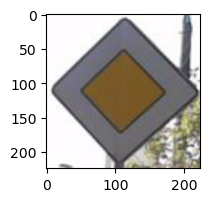

In [150]:
sign_id = 506

sign = valid_dataset.__getitem__(sign_id)['images']
label, score = classifier_predict(model, sign)
plot_sign(sign, label, score)